<a href="https://colab.research.google.com/github/JSRist0028/animalmigration/blob/main/Compile_migration_and_weather_data_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Weather data obtained through Meteostat

Source: Meteostat.net; Raw data: NOAA, Deutscher Wetterdienst 


<a href="https://www.meteostat.net/en/sources" title="Meteostat Sources">Meteostat Sources</a>

## Animal Geolocation data obtained through MoveBank



In [15]:
!pip install geopandas
!pip install shapely
!pip install meteostat 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import math
import datetime
import urllib.request
import json
import datetime as dt
from datetime import datetime
import csv
import codecs
import urllib.request
import sys
import matplotlib.pyplot as plt
import meteostat
from meteostat import Stations, Daily
from dateutil.relativedelta import relativedelta



## Set migration data to use (migration_data_raw) and output file (saved_csv)

In [6]:
migration_data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Migration timing in barnacle geese (Barents Sea) (data from Kölzsch et al. and Shariatinajafabadi et al. 2014).csv") # 4 years
#migration_data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Wader migration German Wadden Sea_ grey plovers.csv") 
#migration_data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Migration of Sabine's gulls from the Canadian High Arctic.csv")
#migration_data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Azores Great Whales Satellite Telemetry Program .csv")
#migration_data_raw = pd.read_csv("") 

saved_csv = "/content/drive/MyDrive/Colab Notebooks/barnacle_geese_data_matrix v2"
migration_data_raw.head()

,event-id,visible,timestamp,location-long,location-lat,ground-speed,heading,height-above-ellipsoid,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,utm-easting,utm-northing,utm-zone,study-timezone,study-local-timestamp
0,362647649,True,2009-02-10 10:00:00.000,6.10583,53.38117,0.0,51.0,1.0,gps,Branta leucopsis,78033,78033,Migration timing in barnacle geese (Barents Se...,307509.632577,5.918577e+06,32N,Central European Time,2009-02-10 11:00:00.000
1,362647650,True,2009-02-10 15:00:00.000,6.18700,53.39283,1.0,351.0,1.0,gps,Branta leucopsis,78033,78033,Migration timing in barnacle geese (Barents Se...,312958.098596,5.919658e+06,32N,Central European Time,2009-02-10 16:00:00.000
2,362647651,True,2009-02-11 10:00:00.000,6.15600,53.40483,0.0,98.0,1.0,gps,Branta leucopsis,78033,78033,Migration timing in barnacle geese (Barents Se...,310950.556688,5.921074e+06,32N,Central European Time,2009-02-11 11:00:00.000
3,362647652,True,2009-02-11 15:00:00.000,6.15683,53.40250,0.0,153.0,1.0,gps,Branta leucopsis,78033,78033,Migration timing in barnacle geese (Barents Se...,310995.384495,5.920813e+06,32N,Central European Time,2009-02-11 16:00:00.000
4,362647653,True,2009-02-12 10:00:00.000,6.13750,53.36217,0.0,61.0,1.0,gps,Branta leucopsis,78033,78033,Migration timing in barnacle geese (Barents Se...,309530.698332,5.916379e+06,32N,Central European Time,2009-02-12 11:00:00.000


In [7]:
def date_to_nth_day(date):#, format='%Y%m%d'):
    date = pd.to_datetime(date)#, format=format)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1
# source: https://codereview.stackexchange.com/questions/154140/interpret-yyyymmdd-as-the-nth-day-of-the-year

migration_data = pd.DataFrame(columns=migration_data_raw.columns)

for i, row in migration_data_raw.iterrows():
  if i>0: # skip first row
    if (date_to_nth_day(row['timestamp']) != date_to_nth_day(migration_data_raw['timestamp'][i-1])): # adds only rows that are on a different day
      migration_data = migration_data.append(row, ignore_index=True)
      #print(i)

In [8]:
# get year
dates = pd.to_datetime(migration_data['timestamp'])
years = pd.DatetimeIndex(dates).year
years
set(years)

{2008, 2009, 2010, 2011}

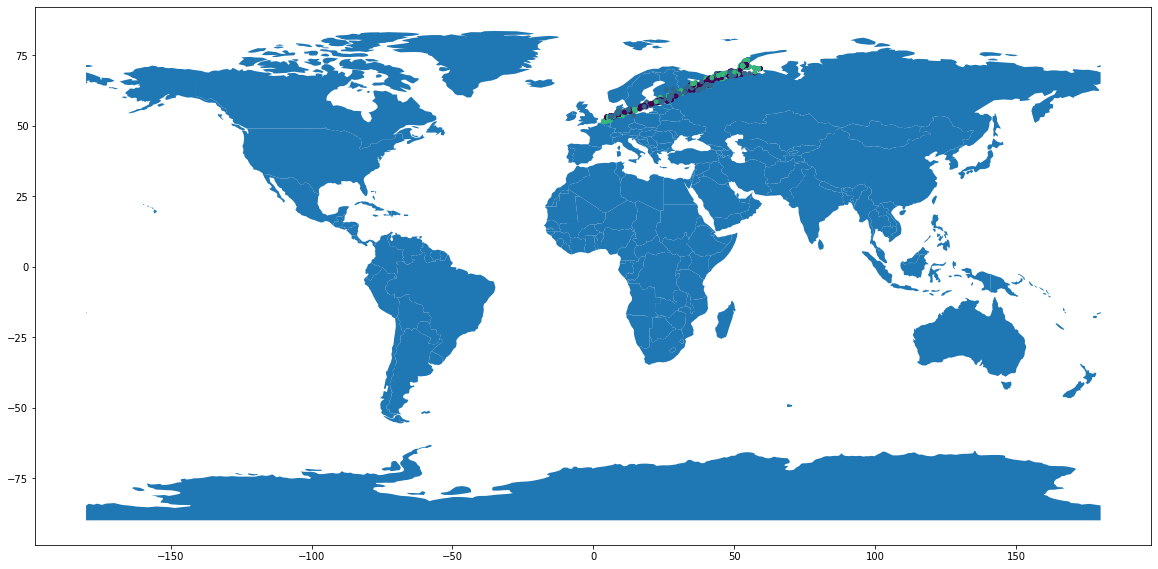

In [9]:
geometry = [Point(xy) for xy in zip(migration_data['location-long'], migration_data['location-lat'])]
gdf = GeoDataFrame(migration_data, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20,12)), marker='o', c = years, markersize=15);


In [10]:
import csv
from csv import writer
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)


In [11]:
!pip install meteostat -U

Requirement already up-to-date: meteostat in /usr/local/lib/python3.7/dist-packages (1.2.2)


In [12]:
# try getting meteostat to work

from meteostat import Stations, Daily
from datetime import datetime
import matplotlib.pyplot as plt

stations = Stations()
stations = stations.nearby(lat = 33.52068, lon = -86.81176)
station = stations.fetch(1)

data = Daily(station, start = datetime(2020, 10, 1), end = datetime(2020, 10, 15))
data = data.fetch()


In [13]:
 from dateutil.relativedelta import relativedelta

 def getWeather(stations, lat, long, mig_datetime):
   #stations = Stations()
   stations = stations.nearby(lat = 33.52068, lon = -86.81176,radius=40000) #note: radius is in meters (40k meters ~ 25 miles)
   station = stations.fetch(1)
   weather_data = Daily(station, start=mig_datetime,end=(mig_datetime + relativedelta(days=1)))
   weather_data = weather_data.fetch()
   weather_data_temp = weather_data[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']].values.tolist()
   for i in range(2, stations.count()-1):
     if (np.isnan(weather_data_temp).any):
      station = stations.fetch(i)
      weather_data = Daily(station, start=mig_datetime,end=(mig_datetime + relativedelta(days=1)))
      weather_data = weather_data.fetch()
      #print(weather_data['wpgt'].values.tolist())
      if np.isnan(weather_data_temp[0][0]): #tavg
        [weather_data_temp[0][0]] = weather_data['tavg'].values.tolist()
      if np.isnan(weather_data_temp[0][1]): #tmin tmax
        [weather_data_temp[0][1]] = weather_data['tmin'].values.tolist()
        [weather_data_temp[0][2]] = weather_data['tmax'].values.tolist()
      if np.isnan(weather_data_temp[0][3]): #prcp
        [weather_data_temp[0][3]] = weather_data['prcp'].values.tolist()
      if np.isnan(weather_data_temp[0][4]): #snow
        [weather_data_temp[0][4]] = weather_data['snow'].values.tolist()
      if np.isnan(weather_data_temp[0][5]): #wdir
        [weather_data_temp[0][5]] = weather_data['wdir'].values.tolist()
      if np.isnan(weather_data_temp[0][6]): #wspd
        [weather_data_temp[0][6]] = weather_data['wspd'].values.tolist()
      if np.isnan(weather_data_temp[0][7]): #wpgt
        [weather_data_temp[0][7]] = weather_data['wpgt'].values.tolist()
      if np.isnan(weather_data_temp[0][8]): #pres
        [weather_data_temp[0][8]] = weather_data['pres'].values.tolist()
      if np.isnan(weather_data_temp[0][9]): #tsun
        [weather_data_temp[0][9]] = weather_data['tsun'].values.tolist()
   station_data = station.values[0]
   return [weather_data_temp, station_data]
stations = Stations()
mig_date = dt.datetime.strptime(migration_data['timestamp'][25], "%Y-%m-%d %H:%M:%S.000") 
[aa, bb]=getWeather(stations, 10,100, mig_date)
aa

[[21.0, 16.7, 26.7, 0.0, 0.0, nan, 10.4, nan, 1020.7, nan]]

In [14]:
records = []

# Create header
header = ['row number','timestamp', 'latitude', 'longitude', 'height', 'speed', 'heading', 'birdID', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'station_lat', 'station_long']
append_list_as_row(saved_csv, header)

for i, row in migration_data.iterrows():
  if True: #(i >= 0) & (i<100):
    latitude = row['location-lat']
    longitude = row['location-long']
    birdID = row['individual-local-identifier']
    timestamp = row['timestamp']
    speed	= row['ground-speed']
    heading	= row['heading'] 
    height = row['height-above-ellipsoid']

    if math.isnan(latitude) or math.isnan(longitude) or (latitude==0 and longitude ==0):
      print("bad coordinates {},{}".format(latitude, longitude))
      continue
    #if timestamp < start_date:
    #  print("Bad timestamp {}".format(timestamp))
    #  continue
    try:
      #datetime = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:00:00.000')
      mig_datetime = dt.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S.000")  #timestamp.apply(lambda x :pd.to_datetime(str(x)))
    except:
      print("Bad date format {}".format(timestamp))
      continue 

    #latitude ='{:.5f}'.format(latitude)
    #longitude = #'{:.5f}'.format(longitude)

    # Get closest weather station
    try:
#      stations = Stations()
#      [weather_data_temp, station_data] = getWeather(stations, latitude, longtitude)
      stations = Stations()
      [weather_data_temp, station_data]=getWeather(stations, latitude, longitude, mig_datetime)
#      stations = stations.nearby(latitude,longitude)
#      #for station in stations
#      station = stations.fetch(1)
#      # Get daily data at the selected weather station
#      weather_data = Daily(station, mig_datetime, mig_datetime + relativedelta(days=1))
#      weather_data = weather_data.fetch()
      
#      weather_data_temp = weather_data[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']].values.tolist()
#      station_data = station.values[0]
    except:
      print("Trouble loading station at {}, {}, on {}".format(latitude, longitude, mig_datetime))
    #print("Successfully loaded weather data: {}".format(weather_data))
    # assemble data into matrix 
    # [ timestamp, latitude, longitude, tavg, tmin, tmax, wdir, wspd]
    #np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
    #data_matrix = np.row_stack((data_matrix,np.array((timestamp, latitude, longitude, weather_data['tavg'], weather_data['tmin'], weather_data['tmax'], weather_data['wdir'], weather_data['wspd']))))
    try:
      #weather_data_temp = weather_data[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']].values.tolist()
      #station_data = station.values[0]
      tavg_temp, tmin_temp, tmax_temp, prcp_temp, snow_temp, wdir_temp, wspd_temp, wpgt_temp, pres_temp, tsun_temp = weather_data_temp[0]
      new_row = [i, mig_datetime, latitude, longitude, height, speed, heading, birdID, tavg_temp, tmin_temp, tmax_temp, prcp_temp, snow_temp, wdir_temp, wspd_temp, wpgt_temp, pres_temp, tsun_temp, station_data[5], station_data[6]]
      append_list_as_row(saved_csv, new_row)
      print(i)
      #print(new_row)
    except:
      print("Problem loading weather data at {}, {} on {}".format(latitude, longitude, datetime))
      print(weather_data)
      try:
        new_row = [i, mig_datetime, latitude, longitude, height, speed, heading, birdID,'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', station_data[5], station_data[6]]
        append_list_as_row(saved_csv, new_row)
      except:
        new_row = [i, mig_datetime, latitude, longitude, height, speed, heading, birdID,'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
        append_list_as_row(saved_csv, new_row)
  


Streaming output truncated to the last 5000 lines.
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145